# 1. Extracting and merging temperature pairs in eICU2:

# Defines and Imports

In [1]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [2]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno

import numpy as np
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


In [3]:
# variables to create temperature pairs
temp_pairs_vars = [
    'patientunitstayid',
    'nursingchartoffset',
    'Temp_C',
    'Temp_F'
]
# base date to create temperature pairs using the intial year for eICU2
base_date = pd.Timestamp('2019-01-01')

# columns to keep when merging for temperature pairs
# include offset here since
eicu2_cols = [
    'patientunitstayid',
    'datetime_charted',
    'Temp_C',
    'nursingchartoffset'
]
# temperature location mappings
temperature_location_mappings = {}
# dictionary mappings to identify correct temperature location recorded
temperature_location_mappings['eicu'] = {
    'temporal': [
        'Temporal', 'te,poral', 'teemporal', 'tem', 'tem[oral', 'tem[poral', 'temoporal', 'temoporol',
        'temopral', 'temoral', 'temp', 'temp  art', 'temp art', 'temp artery', 'temp at',
        'temp, art', 'temp.', 'tempa rt',
        'tempart', 'temperal',
        'temple', 'tempm art', 'tempoal', 'tempoarl', 'tempoeral', 'tempoiral', 'tempooral', 'tempor',
        'tempora', 'tempora;', 'temporak', 'temporal', 'temporal ', 'temporal  artery', 'temporal art',
        'temporal artery', 'temporal artery scan', 'temporal scan', 'temporal,', 'temporalf', 'temporarl',
        'temporol', 'temporral', 'temporsl', 'tempota', 'tempral', 'temprl', 'temproal', 'temproral',
        'tenporal', 'termporal', 'tewmporal', 'tmp', 'tmporal', '.ta', 'ta', 'forehead', ' temporal',
        'tymporal'
    ],
    'oral': [
        'Oral', 'o', 'o.', 'oal', 'oarl', 'olral', 'or', 'or ', 'or36.6al', 'ora', 'ora;', 'orak', 'oral',
        'oral ', 'oral/axillary', 'oral3.', 'oral49', 'orala', 'orall', 'orally', 'orl', 'orla', 'orsl',
        'otal'
    ],
    'core': [
        'Core', 'core', 'pa catheter', 'esophageal', 'esophageal probe', 'temperature sensing urinary catheter',
        'intravascular (swan)', 'core urinary catheter', 'bladder', 'eso', 'core temperature', 'bladr', 'foley ',
        'gastric tube, oral', 'bldr', 'foley', 'f.', 'foley', 'bldr', 'esoph', 'catheter', 'pa cath',
        'core central line', '.swan', 'esophageal ', 'pa', 'intravascular', 'swan', 'swan ganz', 'esophogeal',
        'esphageal', 'core ', 'foley temp'
    ],
    'rectal': [
        'rc', 'rctal', 're', 'rec', 'rec ', 'rec.', 'recatl', 'recrtal', 'rect', 'recta', 'recta;', 'rectaal',
        'rectal', 'rectal ', 'rectal  probe', 'rectal temp probe and foley temp probe', 'rectal;', 'rectall',
        'rectally', 'rectoal', 'rectsl', 'r', 'r.', '.rec'
    ],
    'other': [
        'axillary', 'axilla', 'ax', 'axllry', 'axi', 'axl', 'ax ', 'axilalry', 'axillaru', 'axilary'
    ],
    'tympanic': [
        'tympanic', 'tym', 'tymp', 'tempanic'
    ]
}

# make sure ethinicty is formatted the same
ethincity_replacements = {
    None: "Unknown",
    "African American": "Black",
    "Black/African American": "Black",
    "Native American": "American Indian / Alaska Native",
    "Indigenous/Native": "American Indian / Alaska Native",
    "Other/Unknown": "Unknown",
    "Hispanic": "Hispanic OR Latino",
    "Asian": "Asian",
}

# Pairs

In [4]:
# make sure to add all other relevant variables here
# ex key eicu2 -> points to eicu2 dataframe
pairs = {}

## eiCU2

In [5]:
# pull temperatures from nurse chart table
%%bigquery eicu2_temperature --project aiwonglab
SELECT * from
(

SELECT patientunitstayid,
nursingchartoffset,
nursingchartcelltypevallabel,
 nursingchartcelltypevalname,
nursingchartvalue
FROM `aiwonglab.eicu_crd_ii_v0_1_0.nursecharting`
WHERE nursingchartcelltypevallabel in ('Temperature')

)

PIVOT (
  ANY_VALUE(nursingchartvalue)
  FOR nursingchartcelltypevalname IN (
            'Temperature (C)' as Temp_C,
            'Temperature (F)' as Temp_F,
            'Temperature Location' as Temp_Location
      )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
display(eicu2_temperature.head(2))

,patientunitstayid,nursingchartoffset,nursingchartcelltypevallabel,Temp_C,Temp_F,Temp_Location
0,6896765,5484,Temperature,38.3,100.9,groin
1,6927482,1491,Temperature,37,98.6,groin


### Data Cleaning

In [7]:
# remove "removed: not cleared" in Temp_C, Temp_F, and Temp_Location
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_C'] != "removed: not cleared"]
eicu2_temperature = eicu2_temperature[eicu2_temperature['Temp_F'] != "removed: not cleared"]
eicu2_cleaned = eicu2_temperature[eicu2_temperature['Temp_Location'] != "removed: not cleared"]
print(
    'unique subjects with temperatures: ',
    len(eicu2_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  189663


In [8]:
# lower strings to make it easier to match temperature location
eicu2_cleaned['Temp_Location'] = eicu2_cleaned['Temp_Location'].str.lower()
# conform to the correct data type
eicu2_cleaned[temp_pairs_vars] = eicu2_cleaned[temp_pairs_vars].apply(pd.to_numeric, downcast='integer')
# round to one decimal point for both Celcius and Farenheit temperatures
eicu2_cleaned["Temp_C"] = round(eicu2_cleaned["Temp_C"], 1)
eicu2_cleaned["Temp_F"] = round(eicu2_cleaned["Temp_F"], 1)

### Drop NA Values in Temperature but Convert When Possible

In [9]:
# if Temp_F is missing but Temp_C is not convert to Temp_F using Temp_C and vice versa
eicu2_cleaned.loc[eicu2_cleaned['Temp_F'].isna() & eicu2_cleaned['Temp_C'].notna(), 'Temp_F'] = round(eicu2_cleaned['Temp_C'] * 9/5 + 32, 1)
eicu2_cleaned.loc[eicu2_cleaned['Temp_C'].isna() & eicu2_cleaned['Temp_F'].notna(), 'Temp_C'] = round((eicu2_cleaned['Temp_F'] - 32) * 5/9, 1)
# drop any NA values still present as temperatures cannot be used
# since these should be pairs of NA values, dropping one of the targeted columns should suffice
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_C'])

### Confrom Temperature Locations to Proper Format

In [10]:
# apply mappings to conform them to proper temperature locations
# add an indicator to show what has been mapped
for key in temperature_location_mappings['eicu']:
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_' + key] = 1
  eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location'].isin(temperature_location_mappings['eicu'][key]),
      'Temp_Location_mapped' ] = key
# drop any observations that haven't been mapped
eicu2_cleaned = eicu2_cleaned.dropna(subset=['Temp_Location_mapped'])
print(
    'unique subjects with temperatures: ',
    len(eicu2_cleaned['patientunitstayid'].unique().tolist())
)

unique subjects with temperatures:  102180


### Convert `nursingchartoffset` into a Datetime Format

In [11]:
eicu2_cleaned['datetime_charted'] = base_date + pd.to_timedelta(eicu2_cleaned['nursingchartoffset'], unit='m')

### Make Temporal-Core Temperature Pairs

In [12]:
# revisit this; just clarify pairs

# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the core temperature data
eicu2_temp_core = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_core'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_core',
    'datetime_charted': 'datetime_charted_core',
    'nursingchartoffset': 'nursingchartoffset_core'
}).sort_values(by=[
    'datetime_charted_core',
]).copy()

# drop rows with null values
eicu2_temp_core = eicu2_temp_core.loc[eicu2_temp_core.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_core = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_core,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_core',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_core_final = eicu2_merged_core.loc[
    eicu2_merged_core['Temp_C_core'].notnull(),
    :
]


In [13]:
display(eicu2_merged_core_final)

,patientunitstayid,datetime_charted_temporal,Temp_C_temporal,nursingchartoffset,datetime_charted_core,Temp_C_core,nursingchartoffset_core
571,6849137,2018-11-10 23:17:00,36.6,-73483,2018-11-11 00:17:00,36.9,-73423
634,6207701,2018-11-13 11:32:00,36.5,-69868,2018-11-13 11:43:00,36.6,-69857
754,6849137,2018-11-16 19:47:00,36.4,-65053,2018-11-16 19:03:00,36.8,-65097
917,6855108,2018-11-20 19:39:00,36.5,-59301,2018-11-20 19:54:00,36.9,-59286
1041,6855108,2018-11-24 04:39:00,36.8,-54441,2018-11-24 03:39:00,37.2,-54501
...,...,...,...,...,...,...,...
130176,6152569,2019-02-04 16:06:00,38.5,49926,2019-02-04 15:06:00,38.5,49866
130391,7158916,2019-02-06 14:48:00,36.3,52728,2019-02-06 13:48:00,35.4,52668
130476,7158916,2019-02-07 07:48:00,35.3,53748,2019-02-07 06:48:00,36.2,53688
130553,6242389,2019-02-08 02:43:00,36.0,54883,2019-02-08 03:43:00,35.9,54943


### Make Temporal-Rectal Temperature Pairs


In [14]:
# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the rectal temperature data
eicu2_temp_rectal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_rectal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_rectal',
    'datetime_charted': 'datetime_charted_rectal',
    'nursingchartoffset': 'nursingchartoffset_rectal'
}).sort_values(by=[
    'datetime_charted_rectal',
]).copy()

# drop rows with null values
eicu2_temp_rectal = eicu2_temp_rectal.loc[eicu2_temp_rectal.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_rectal = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_rectal,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_rectal',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)

# filter to keep only rows with non-null core temperatures
eicu2_merged_rectal_final = eicu2_merged_rectal.loc[
    eicu2_merged_rectal['Temp_C_rectal'].notnull(),
    :
]

In [15]:
display(eicu2_merged_rectal_final)

,patientunitstayid,datetime_charted_temporal,Temp_C_temporal,nursingchartoffset,datetime_charted_rectal,Temp_C_rectal,nursingchartoffset_rectal
3241,6061282,2018-12-22 18:00:00,37.2,-13320,2018-12-22 18:53:00,38.6,-13267
4646,6292863,2018-12-26 11:17:00,35.9,-7963,2018-12-26 11:54:00,34.6,-7926
5204,7159060,2018-12-27 09:06:00,38.0,-6654,2018-12-27 10:06:00,38.1,-6594
5213,7159060,2018-12-27 09:29:00,38.0,-6631,2018-12-27 10:06:00,38.1,-6594
5779,6275365,2018-12-28 03:31:00,29.8,-5549,2018-12-28 03:52:00,35.5,-5528
...,...,...,...,...,...,...,...
119905,6057922,2019-01-14 05:02:00,37.2,19022,2019-01-14 04:02:00,37.2,18962
121862,6143912,2019-01-15 21:09:00,37.9,21429,2019-01-15 20:44:00,38.0,21404
124704,6955232,2019-01-18 23:55:00,38.0,25915,2019-01-19 00:55:00,38.9,25975
124764,6955232,2019-01-19 01:55:00,38.2,26035,2019-01-19 00:55:00,38.9,25975


### Make Temporal-Oral Temperature Pairs


In [16]:
# filter and prepare the temporal temperature data
eicu2_temp_temporal = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_temporal'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_temporal',
    'datetime_charted': 'datetime_charted_temporal',
}).sort_values(by=[
    'datetime_charted_temporal',
]).copy()

# drop rows with null values
eicu2_temp_temporal = eicu2_temp_temporal.loc[eicu2_temp_temporal.notnull().all(axis=1), :]

# filter and prepare the oral temperature data
eicu2_temp_oral = eicu2_cleaned.loc[
    eicu2_cleaned['Temp_Location_oral'] == 1,
    eicu2_cols
].rename(columns={
    'Temp_C': 'Temp_C_oral',
    'datetime_charted': 'datetime_charted_oral',
    'nursingchartoffset': 'nursingchartoffset_oral'
}).sort_values(by=[
    'datetime_charted_oral',
]).copy()

# drop rows with null values
eicu2_temp_oral = eicu2_temp_oral.loc[eicu2_temp_oral.notnull().all(axis=1), :]

# perform a left join, need to drop the null values afterwards
eicu2_merged_oral = pd.merge_asof(
    left=eicu2_temp_temporal,
    right=eicu2_temp_oral,
    left_by='patientunitstayid',
    right_by='patientunitstayid',
    left_on='datetime_charted_temporal',
    right_on='datetime_charted_oral',
    tolerance=pd.Timedelta("60m"),
    direction='nearest',
    suffixes=('', '_todrop'),
    allow_exact_matches=True
)


# filter to keep only rows with non-null core temperatures
eicu2_merged_oral_final = eicu2_merged_oral.loc[
    eicu2_merged_oral['Temp_C_oral'].notnull(),
    :
]

In [17]:
display(eicu2_merged_oral_final)

,patientunitstayid,datetime_charted_temporal,Temp_C_temporal,nursingchartoffset,datetime_charted_oral,Temp_C_oral,nursingchartoffset_oral
163,7171238,2018-10-17 18:32:00,36.9,-108328,2018-10-17 19:32:00,36.7,-108268
245,7158046,2018-10-25 10:25:00,36.6,-97295,2018-10-25 10:58:00,36.8,-97262
272,7160022,2018-10-27 04:35:00,36.4,-94765,2018-10-27 04:46:00,36.8,-94754
316,7160022,2018-10-29 22:26:00,36.3,-90814,2018-10-29 22:50:00,36.8,-90790
331,7160022,2018-10-30 17:54:00,36.2,-89646,2018-10-30 17:36:00,37.0,-89664
...,...,...,...,...,...,...,...
131729,6151617,2019-04-03 00:58:00,36.7,132538,2019-04-03 01:23:00,36.5,132563
131753,6151617,2019-04-04 21:35:00,36.3,135215,2019-04-04 22:19:00,36.9,135259
131773,6151617,2019-04-06 16:27:00,35.3,137787,2019-04-06 15:57:00,36.6,137757
131813,6151617,2019-04-12 01:07:00,36.5,145507,2019-04-12 02:06:00,36.9,145566


### Combine All Pairs into a Unified Dataframe

In [18]:
# rename Temp_C_{}, datetime_charted_{}, and add indicator columns for each
eicu2_merged_rectal_final = eicu2_merged_rectal_final.rename(columns={'Temp_C_rectal': 'Temp_C_reference', 'datetime_charted_rectal': 'datetime_charted_reference', 'nursingchartoffset_rectal': 'nursingchartoffset_reference'})
eicu2_merged_rectal_final["pair"] = "temporal-rectal"
eicu2_merged_core_final = eicu2_merged_core_final.rename(columns={'Temp_C_core': 'Temp_C_reference', 'datetime_charted_core': 'datetime_charted_reference', 'nursingchartoffset_core': 'nursingchartoffset_reference'})
eicu2_merged_core_final["pair"] = "temporal-core"
eicu2_merged_oral_final = eicu2_merged_oral_final.rename(columns={'Temp_C_oral': 'Temp_C_reference', 'datetime_charted_oral': 'datetime_charted_reference', 'nursingchartoffset_oral': 'nursingchartoffset_reference'})
eicu2_merged_oral_final["pair"] = "temporal-oral"

In [19]:
# concat dataframes into one unified dataframe
eicu2_merged_final = pd.concat([eicu2_merged_rectal_final, eicu2_merged_core_final, eicu2_merged_oral_final], axis=0)
# make a new column for the latest offset, which refers to the latest temperature taken
eicu2_merged_final['later_datetime'] = eicu2_merged_final[['datetime_charted_temporal', 'datetime_charted_reference']].max(axis=1)
eicu2_merged_final['later_offset'] = eicu2_merged_final.apply(
    lambda row: row['nursingchartoffset'] if row['later_datetime'] == row['datetime_charted_temporal'] else row['nursingchartoffset_reference'],
    axis=1
)

In [20]:
display(eicu2_merged_final)

Output hidden; open in https://colab.research.google.com to view.

## Upload

In [21]:
import pandas_gbq
pairs["eicu2"] = eicu2_merged_final

project_id = "spring-carving-271217"
dataset_id = "test"

def create_table_id(project_id, dataset_id, tab_id):

  return f"{project_id}.{dataset_id}.{tab_id}"

for t_name, t_df in pairs.items():

  table_id = create_table_id(project_id, dataset_id, t_name)
  t_df.to_gbq(table_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


# Add Time-Series Characteristics

In [22]:
# grabs google sheet
def get_vars_df(sheet_id, gid):

  return pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}')

In [23]:
# subquery to pull table

# add a maxmimum timestamp to use as the offset
# redo calculation
def create_subquery(pairs_table,
                    temperature_time,
                    var_type,
                    var_name,
                    var_new_name,
                    var_window_low_hr,
                    var_window_upper_hr,
                    var_source_table,
                    var_foreign_key,
                    var_timestamp):


    if temperature_time == "later_datetime":
      time_diff = f"TIMESTAMP_DIFF(CAST(table.{var_timestamp} AS TIMESTAMP), CAST(pairs.{temperature_time} AS TIMESTAMP), MINUTE)"
    # print(var_name)
    elif temperature_time == "later_offset":
      time_diff = f"table.{var_timestamp} - pairs.{temperature_time} "

    return f"""
    {var_type}_{var_name} AS (
      SELECT * FROM (
        SELECT
          pairs.{var_foreign_key},
          {var_name},
          pairs.{temperature_time},
          {time_diff} AS delta_{var_type}_{var_new_name},
          ROW_NUMBER() OVER(PARTITION BY pairs.{var_foreign_key}, pairs.{temperature_time}
                            ORDER BY ABS({time_diff}) ASC) AS seq
        FROM `{pairs_table}` pairs
        LEFT JOIN `{var_source_table}` AS table
        ON table.{var_foreign_key} = pairs.{var_foreign_key}
        AND {var_name} IS NOT NULL
        AND {time_diff} BETWEEN {var_window_low_hr} * 60 AND {var_window_upper_hr} * 60
      )
      WHERE seq = 1
    )
    """

In [24]:
def create_complete_query(pairs_table, vars_df, temporal_time):

  subquery_list = []

  # Iterate over each row in df
  for index, row in vars_df.iterrows():

      subquery = create_subquery(pairs_table,
                                 temporal_time,
                                 row['var_type'],
                                 row['var_name'],
                                 row['var_new_name'],
                                 row['var_window_low_hr'],
                                 row['var_window_upper_hr'],
                                 row['var_source_table'],
                                 row['var_foreign_key'],
                                 row['var_timestamp'])
      subquery_list.append(subquery)

  # Now you have your subqueries, join them into one string
  subquery_string = ",\n\n".join(subquery_list)
  final_query = f"""
  WITH
  {subquery_string}
  SELECT
      pairs.*,
      {" , ".join([f"{row.var_type}_{row.var_name}.delta_{row.var_type}_{row.var_new_name}, {row.var_type}_{row.var_name}.{row.var_name} AS {row.var_type}_{row.var_new_name}" for index, row in vars_df.iterrows()])}
  FROM `{pairs_table}` pairs
  {" ".join([f"LEFT JOIN {row.var_type}_{row.var_name} ON {row.var_type}_{row.var_name}.{row.var_foreign_key} = pairs.{row.var_foreign_key} AND {row.var_type}_{row.var_name}.{temporal_time} = pairs.{temporal_time}" for index, row in vars_df.iterrows()])}
  """
  return final_query

In [25]:
temporal_time = "later_offset"
pairs_table = "spring-carving-271217.test.eicu2"

sheet_id = "1SOWmaaq_FR5kkMXYnM1-6V7SR8vd0PPPuhvSmSpB_jA"
gid = "891660135"
vars_df = get_vars_df(sheet_id, gid)

query = create_complete_query(pairs_table, vars_df, temporal_time)
# print(query)
client = bigquery.Client(project='spring-carving-271217')
eicu2_df = client.query(query).to_dataframe()

In [26]:
display(eicu2_df)

,patientunitstayid,datetime_charted_temporal,Temp_C_temporal,nursingchartoffset,datetime_charted_reference,Temp_C_reference,nursingchartoffset_reference,pair,later_datetime,later_offset,...,delta_sofa_future_coagulation_24hr,sofa_future_coagulation_24hr,delta_sofa_future_liver_24hr,sofa_future_liver_24hr,delta_sofa_future_cardiovascular_24hr,sofa_future_cardiovascular_24hr,delta_sofa_future_cns_24hr,sofa_future_cns_24hr,delta_sofa_future_renal_24hr,sofa_future_renal_24hr
0,6152253,2018-12-31 23:37:00+00:00,36.1,-23,2019-01-01 00:07:00+00:00,34.0,7,temporal-core,2019-01-01 00:07:00+00:00,7,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,6152253,2019-01-01 00:09:00+00:00,36.1,9,2019-01-01 00:07:00+00:00,34.0,7,temporal-core,2019-01-01 00:09:00+00:00,9,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,6155913,2019-01-02 15:51:00+00:00,36.1,2391,2019-01-02 14:51:00+00:00,34.0,2331,temporal-oral,2019-01-02 15:51:00+00:00,2391,...,1509,0,1509,0,1509,1,1509,2,1509,3
3,6155222,2018-12-31 23:20:00+00:00,36.7,-40,2019-01-01 00:20:00+00:00,34.0,20,temporal-core,2019-01-01 00:20:00+00:00,20,...,1540,3,1540,0,1540,4,1540,4,1540,4
4,6155222,2019-01-01 00:04:00+00:00,36.7,4,2019-01-01 00:20:00+00:00,34.0,20,temporal-core,2019-01-01 00:20:00+00:00,20,...,1540,3,1540,0,1540,4,1540,4,1540,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,6303616,2019-01-01 13:58:00+00:00,37.2,838,2019-01-01 14:22:00+00:00,37.6,862,temporal-oral,2019-01-01 14:22:00+00:00,862,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4390,7162684,2018-12-31 23:03:00+00:00,36.3,-57,2019-01-01 00:03:00+00:00,37.6,3,temporal-oral,2019-01-01 00:03:00+00:00,3,...,1557,0,1557,0,1557,1,1557,3,1557,0
4391,6158664,2018-12-31 23:54:00+00:00,37.7,-6,2019-01-01 00:03:00+00:00,37.6,3,temporal-oral,2019-01-01 00:03:00+00:00,3,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4392,6152808,2019-01-08 12:37:00+00:00,37.3,10837,2019-01-08 12:10:00+00:00,37.6,10810,temporal-oral,2019-01-08 12:37:00+00:00,10837,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Add Patient Characteristics

In [29]:
# grab patient info from dervied icu stays table and patient table
%%bigquery eicu2_patv2 --project aiwonglab

# note that uniquepid is not "unique" as different patients hold the same uniquepid
SELECT DISTINCT
    icu.uniquepid AS subject_id,
    icu.patienthealthsystemstayid AS hospital_admission_id,
    icu.patientunitstayid AS icustay_id,
    'eicu2' AS source_db,
    icu.hospitalid,
    hosp.numbedscategory,
    hosp.teachingstatus,
    hosp.region,
    CASE
        WHEN icu.age = '> 89' THEN CAST(90 AS STRING)
        ELSE icu.age
    END AS admission_age,
    CASE
        WHEN pat.gender = "Female" THEN 1
        ELSE 0
    END AS sex_female,
    icu.admissionweight AS weight_admission,
    icu.admissionheight AS height_admission,
    CASE
        WHEN icu.admissionheight > 0 THEN icu.admissionweight / (POWER(icu.admissionheight/100, 2))
        ELSE NULL
    END AS BMI_admission,
    icu.hospitaladmitoffset AS offset_hospital_admit,
    icu.hospitaldischargeoffset AS offset_hospital_discharge,
    icu.unitadmitoffset AS offset_icu_admit,
    icu.unitdischargeoffset AS offset_icu_discharge,
    (icu.hospitaldischargeoffset - icu.hospitaladmitoffset)/60 AS los_hospital,
    icu.icu_los_hours AS los_ICU,
    icu.hosp_mort AS in_hospital_mortality,
    pat.ethnicity AS race_ethnicity,
    pat.hospitalDischargeStatus AS clinical_outcome,
    pat.unitType AS icu_unit,
    cci.charlson_score AS charlson_score
FROM `eicu_crd_ii_v0_1_0_derived.icustay_detail` AS icu
LEFT JOIN `eicu_crd_ii_v0_1_0.patient` AS pat
  ON pat.patienthealthsystemstayid = icu.patienthealthsystemstayid
LEFT JOIN `eicu_crd_ii_v0_1_0.hospital` AS hosp
  ON pat.hospitalid = hosp.hospitalid
LEFT JOIN `spring-carving-271217.test.cci` AS cci
  ON cci.patientunitstayid = icu.patientunitstayid

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
# clean race_ethnicity variable before merging
eicu2_patv2["race_ethnicity"] = eicu2_patv2["race_ethnicity"].replace(ethincity_replacements, inplace=False)
eicu2_patv2["race_ethnicity"].unique()
# convert offsets to timestamp
eicu2_patv2['offset_hospital_admit'] = base_date + pd.to_timedelta(eicu2_patv2['offset_hospital_admit'], unit='m')
eicu2_patv2['offset_hospital_discharge'] = base_date + pd.to_timedelta(eicu2_patv2['offset_hospital_discharge'], unit='m')
eicu2_patv2['offset_icu_admit'] = base_date + pd.to_timedelta(eicu2_patv2['offset_icu_admit'], unit='m')
eicu2_patv2['offset_icu_discharge'] = base_date + pd.to_timedelta(eicu2_patv2['offset_icu_discharge'], unit='m')

eicu2_patv2 = eicu2_patv2.rename(columns={
    'offset_hospital_admit': 'datetime_hospital_admit',
    'offset_hospital_discharge': 'datetime_hospital_discharge',
    'offset_icu_admit': 'datetime_icu_admit',
    'offset_icu_discharge': 'datetime_icu_discharge',
})

# Finalize

## Merge Horizontally

In [32]:
# double check this
filtered_patv2 = eicu2_patv2.drop_duplicates(subset='icustay_id', keep='first')

eicu2_final = eicu2_df.merge(
    filtered_patv2,
    left_on='patientunitstayid',
    right_on='icustay_id',
    how='left'
)

In [33]:
display(eicu2_final)

,patientunitstayid,datetime_charted_temporal,Temp_C_temporal,nursingchartoffset,datetime_charted_reference,Temp_C_reference,nursingchartoffset_reference,pair,later_datetime,later_offset,...,datetime_hospital_discharge,datetime_icu_admit,datetime_icu_discharge,los_hospital,los_ICU,in_hospital_mortality,race_ethnicity,clinical_outcome,icu_unit,charlson_score
0,6152253,2018-12-31 23:37:00+00:00,36.1,-23,2019-01-01 00:07:00+00:00,34.0,7,temporal-core,2019-01-01 00:07:00+00:00,7,...,2019-01-10 11:39:00,2019-01-01,2019-01-01 11:32:00,231.466667,12.0,0,Black,Alive,Med-Surg ICU,2
1,6152253,2019-01-01 00:09:00+00:00,36.1,9,2019-01-01 00:07:00+00:00,34.0,7,temporal-core,2019-01-01 00:09:00+00:00,9,...,2019-01-10 11:39:00,2019-01-01,2019-01-01 11:32:00,231.466667,12.0,0,Black,Alive,Med-Surg ICU,2
2,6155913,2019-01-02 15:51:00+00:00,36.1,2391,2019-01-02 14:51:00+00:00,34.0,2331,temporal-oral,2019-01-02 15:51:00+00:00,2391,...,2019-01-06 08:05:00,2019-01-01,2019-01-06 08:05:00,146.033333,128.0,1,Caucasian,Expired,Med-Surg ICU,2
3,6155222,2018-12-31 23:20:00+00:00,36.7,-40,2019-01-01 00:20:00+00:00,34.0,20,temporal-core,2019-01-01 00:20:00+00:00,20,...,2019-01-09 02:28:00,2019-01-01,2019-01-08 07:18:00,199.150000,175.0,0,Caucasian,Alive,Med-Surg ICU,6
4,6155222,2019-01-01 00:04:00+00:00,36.7,4,2019-01-01 00:20:00+00:00,34.0,20,temporal-core,2019-01-01 00:20:00+00:00,20,...,2019-01-09 02:28:00,2019-01-01,2019-01-08 07:18:00,199.150000,175.0,0,Caucasian,Alive,Med-Surg ICU,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,6303616,2019-01-01 13:58:00+00:00,37.2,838,2019-01-01 14:22:00+00:00,37.6,862,temporal-oral,2019-01-01 14:22:00+00:00,862,...,2019-01-05 06:51:00,2019-01-01,2019-01-02 13:46:00,106.983333,38.0,0,Unknown,Alive,Cardiac ICU,5
4390,7162684,2018-12-31 23:03:00+00:00,36.3,-57,2019-01-01 00:03:00+00:00,37.6,3,temporal-oral,2019-01-01 00:03:00+00:00,3,...,2019-01-29 00:08:00,2019-01-01,2019-01-09 10:49:00,676.116667,203.0,1,Caucasian,Expired,Med-Surg ICU,4
4391,6158664,2018-12-31 23:54:00+00:00,37.7,-6,2019-01-01 00:03:00+00:00,37.6,3,temporal-oral,2019-01-01 00:03:00+00:00,3,...,2019-01-10 02:29:00,2019-01-01,2019-01-01 18:49:00,227.783333,19.0,0,Caucasian,Alive,Neuro ICU,2
4392,6152808,2019-01-08 12:37:00+00:00,37.3,10837,2019-01-08 12:10:00+00:00,37.6,10810,temporal-oral,2019-01-08 12:37:00+00:00,10837,...,2019-01-11 18:26:00,2019-01-01,2019-01-05 17:35:00,385.566667,114.0,0,Black,Alive,Med-Surg ICU,0


<Axes: >

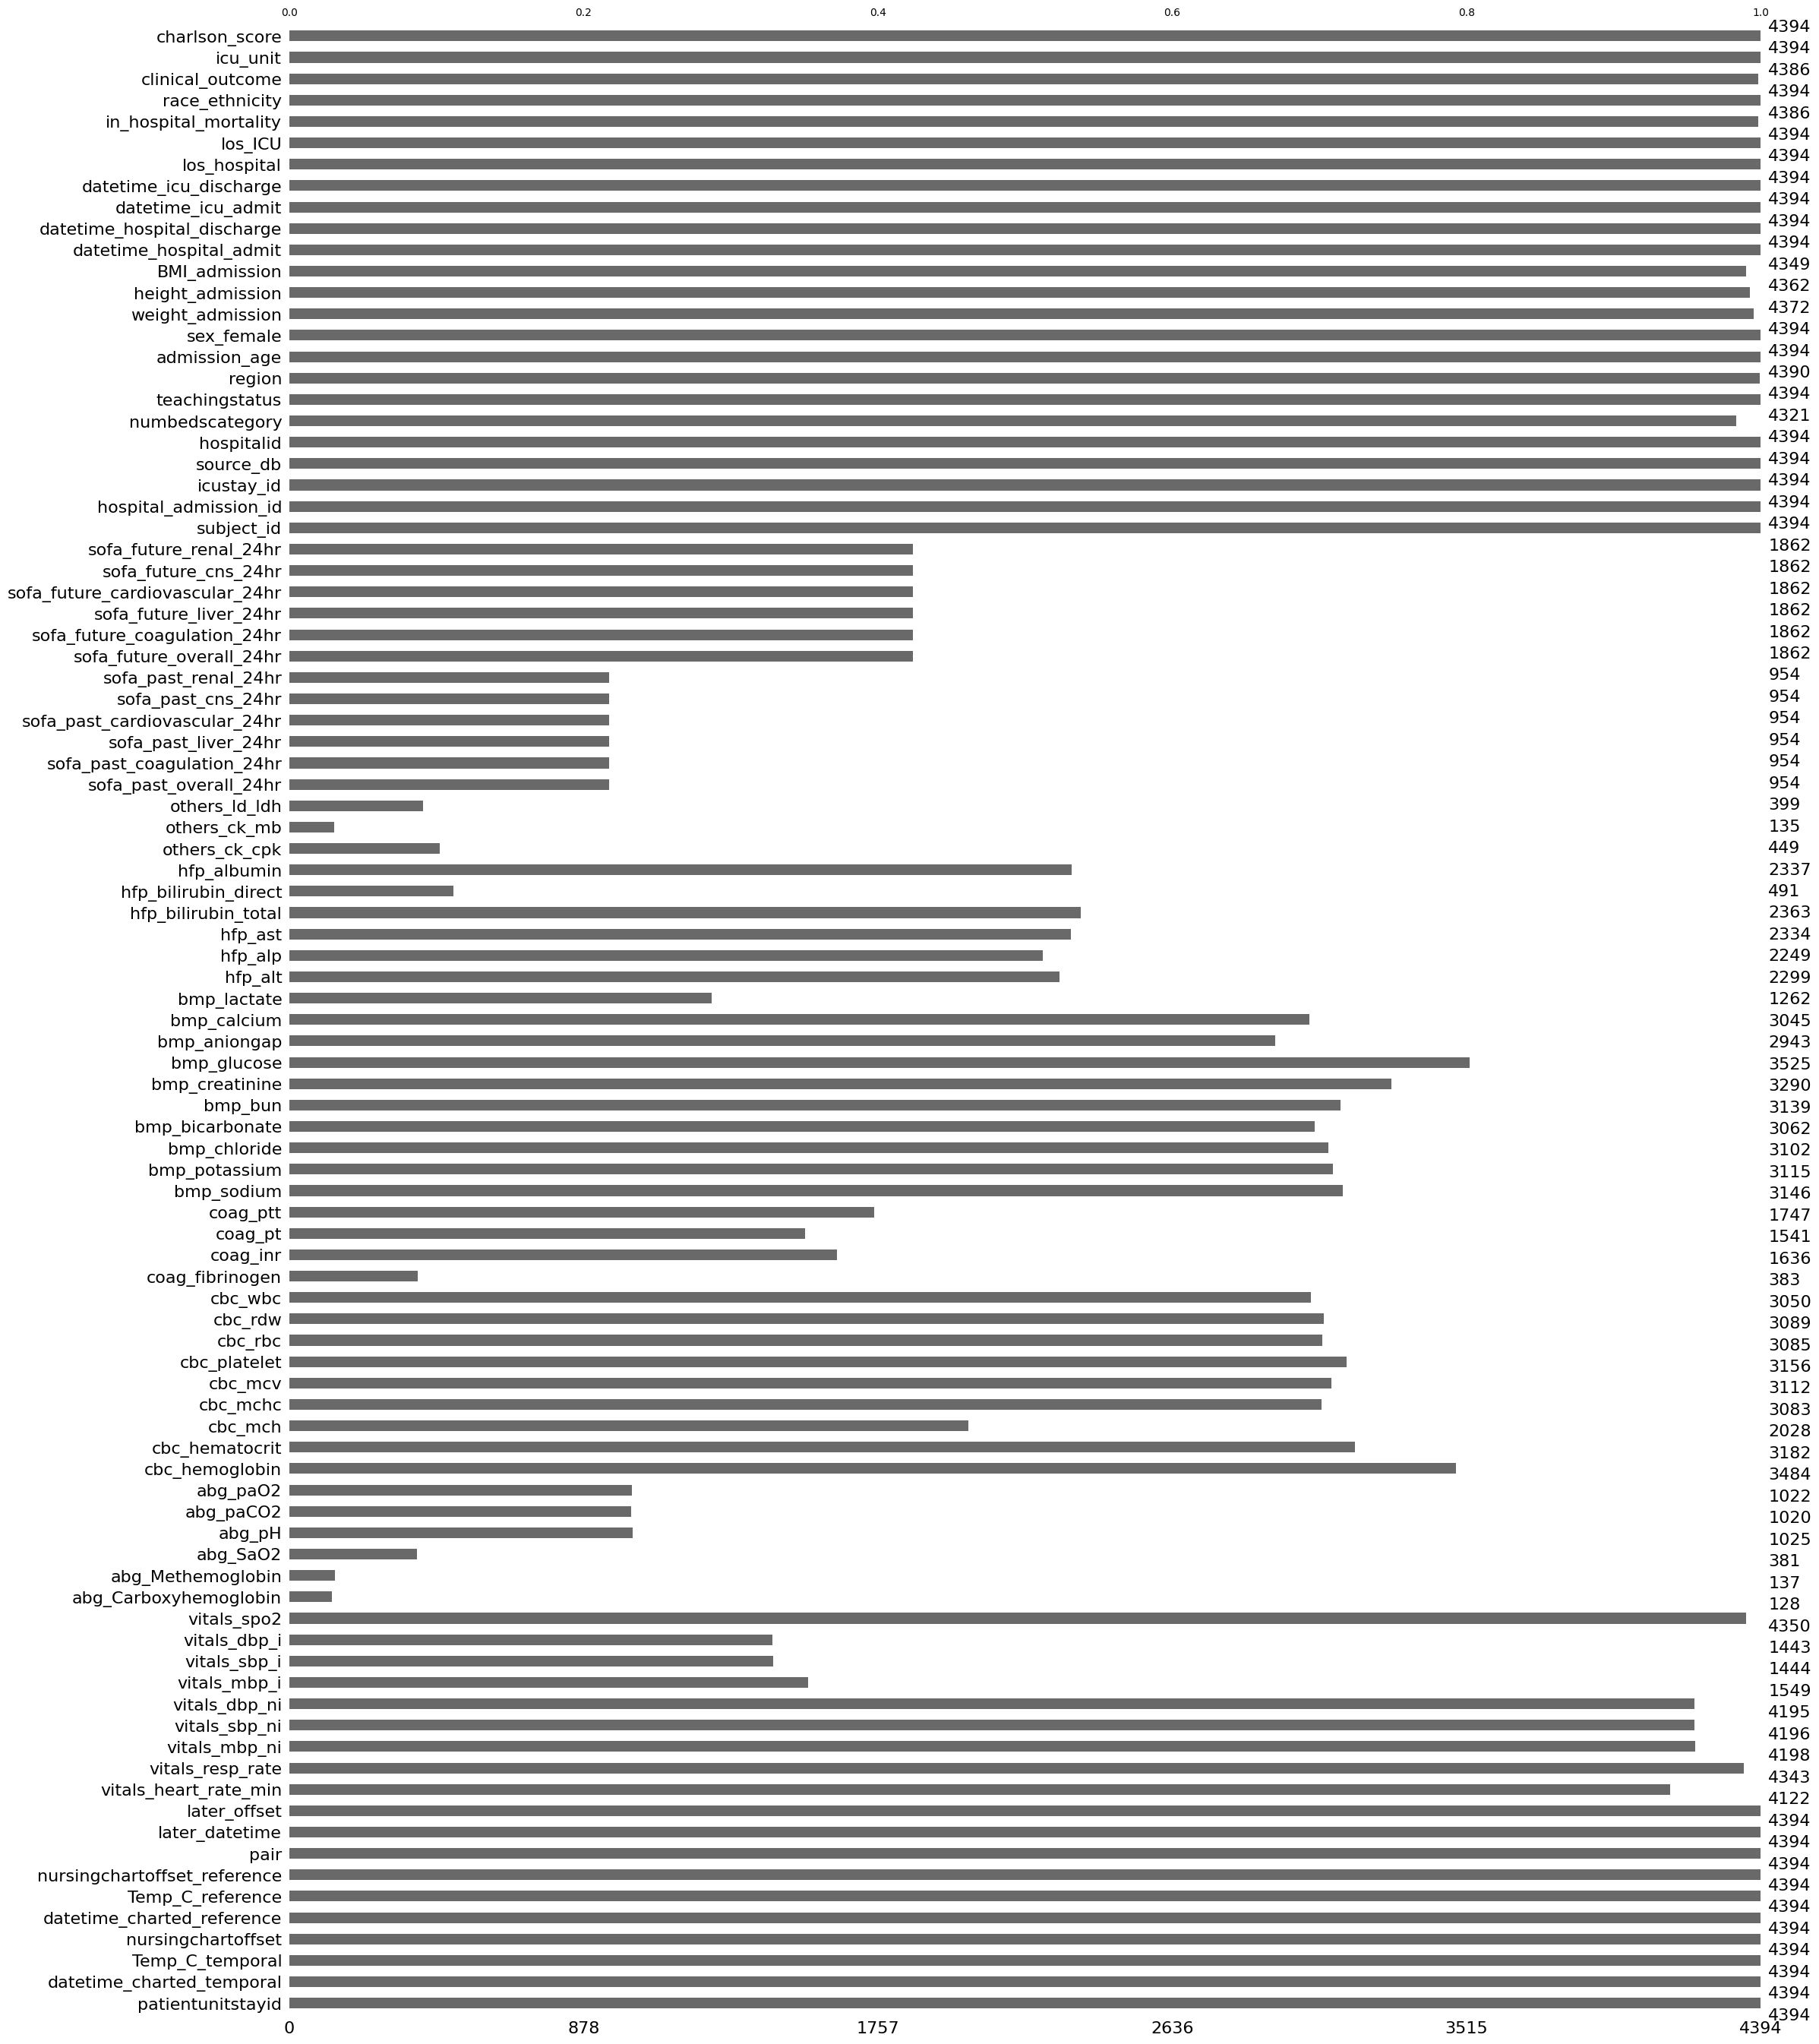

In [34]:
# add missigness plot
mdf = eicu2_final[[column for column in eicu2_final.columns if not column.startswith('delta_')]]
msno.bar(mdf)

In [36]:
def rename_columns(dataframe, column_names_old, column_names_new):
    column_mapping = dict(zip(column_names_old, column_names_new))
    print(column_mapping)
    dataframe.rename(columns=column_mapping, inplace=True)

# your first list here
column_names_old = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'height_admission',
    'BMI_admission', 'datetime_hospital_admit', 'datetime_hospital_discharge', 'datetime_icu_admit',
    'datetime_icu_discharge', 'los_hospital', 'los_ICU', 'charlson_score',
    'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal', 'abg_pH', 'abg_pCO2', 'abg_paO2', 'abg_SaO2',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'vitals_heart_rate', 'vitals_resp_rate',
    'vitals_mbp_ni', 'vitals_sbp_ni', 'vitals_dbp_ni', 'vitals_mbp_i', 'vitals_sbp_i', 'vitals_dbp_i',
    'vitals_tspo2', 'cbc_hemoglobin', 'cbc_hematocrit', 'cbc_mch', 'cbc_mchc', 'cbc_mcv', 'cbc_platelet',
    'cbc_rbc', 'cbc_rdw', 'cbc_wbc', 'coag_fibrinogen', 'coag_inr', 'coag_pt', 'coag_ptt', 'bmp_sodium',
    'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine', 'bmp_glucose',
    'bmp_aniongap', 'bmp_calcium', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total',
    'hfp_bilirubin_direct', 'hfp_albumin', 'others_ck_cpk', 'others_ck_mb', 'others_ld_ldh',
    'sofa_past_overall_24hr', 'sofa_past_coagulation_24hr',
    'sofa_past_liver_24hr', 'sofa_past_cardiovascular_24hr', 'sofa_past_cns_24hr', 'sofa_past_renal_24hr',
    'sofa_future_overall_24hr', 'sofa_future_coagulation_24hr', 'sofa_future_liver_24hr',
    'sofa_future_cardiovascular_24hr', 'sofa_future_cns_24hr', 'sofa_future_renal_24hr'
]

# your second list here
# charlson score is fine, no need to split
# replace spo2 and sao2 with correct temps
# temp_c should be vitals spo2
column_names_new = [
    'Subject ID', 'Hospital Admission ID', 'ICU Stay ID', 'Source Database', 'Hospital ID', 'Number of Beds Category',
    'Teaching Status', 'US Census Region', 'Admission Age', 'Female Sex', 'Admission Weight', 'Admission Height',
    'Admission BMI', 'Datetime of Hospital Admission', 'Datetime of Hospital Discharge', 'Datetime of ICU Admission',
    'Datetime of ICU Discharge', 'LOS Hospital', 'LOS ICU', 'Comorbidity Score (Charlson)',
    'In-Hospital Mortality', 'Race-Ethnicity', 'Temporal Timestamp', 'ABG pH', 'ABG pCO2', 'ABG paO2', 'ABG SaO2',
    'Carboxyhemoglobin', 'Methemoglobin', 'Reference Timestamp', 'Vitals Heart Rate', 'Vitals Resp Rate',
    'Vitals niMBP', 'Vitals niSBP', 'Vitals niDBP', 'Vitals iMBP', 'Vitals iSBP', 'Vitals iDBP',
    'Vitals SpO2', 'CBC Hemoglobin', 'CBC Hematocrit', 'CBC MCH', 'CBC MCHC', 'CBC MCV', 'CBC Platelets',
    'CBC RBC', 'CBC RDW', 'CBC WBC', 'Coagulation Fibrinogen', 'Coagulation INR', 'Coagulation PT', 'Coagulation PTT', 'Sodium',
    'Potassium', 'Chloride', 'Bicarbonate', 'Blood Urea Nitrogen', 'Creatinine', 'Glucose',
    'Anion-gap', 'Calcium', 'Lactate', 'Alanine Transaminase', 'Alkaline Phosphatase', 'Aspartate Transaminase', 'Bilirubin Total',
    'Bilirubin Direct', 'Albumin', 'Creatine Kinase', 'Creatine Kinase MB', 'Lactate Dehydrogenase',
    'SOFA Past Overall 24hr', 'SOFA Past Coagulation 24hr',
    'SOFA Past Liver 24hr', 'SOFA Past Cardiovascular 24hr', 'SOFA Past CNS 24hr', 'SOFA Past Renal 24hr',
    'SOFA Future Overall 24hr', 'SOFA Future Coagulation 24hr', 'SOFA Future Liver 24hr',
    'SOFA Future Cardiovascular 24hr', 'SOFA Future CNS 24hr', 'SOFA Future Renal 24hr'
]

# define columns of interest, talk about columns retained in questions later
columns_retained = [
    'subject_id', 'hospital_admission_id', 'icustay_id', 'source_db', 'hospitalid', 'numbedscategory',
    'teachingstatus', 'region', 'admission_age', 'sex_female', 'weight_admission', 'datetime_hospital_admit',
    'datetime_hospital_discharge', 'datetime_icu_admit', 'datetime_icu_discharge', 'los_hospital', 'los_ICU',
    'charlson_score', 'in_hospital_mortality', 'race_ethnicity', 'datetime_charted_temporal',
    'abg_Carboxyhemoglobin', 'abg_Methemoglobin', 'datetime_charted_reference', 'cbc_hemoglobin', 'coag_fibrinogen', 'coag_inr', 'coag_pt',
    'coag_ptt', 'bmp_sodium', 'bmp_potassium', 'bmp_chloride', 'bmp_bicarbonate', 'bmp_bun', 'bmp_creatinine',
    'bmp_glucose', 'bmp_lactate', 'hfp_alt', 'hfp_alp', 'hfp_ast', 'hfp_bilirubin_total', 'hfp_albumin',
    'others_ck_cpk', 'sofa_past_overall_24hr', 'sofa_future_overall_24hr'
]

In [37]:
existing_variables = [col for col in columns_retained if col in column_names_old]
missing_variables = [col for col in columns_retained if col not in column_names_old]

missing_variables

[]

In [38]:
# delta
# using temporal offest for the time varying covariate pull
# should I redo the patient characteristcs to match the spreadsheet
# charlson score
# hemoglobin variable abg, ask

{'subject_id': 'Subject ID', 'hospital_admission_id': 'Hospital Admission ID', 'icustay_id': 'ICU Stay ID', 'source_db': 'Source Database', 'hospitalid': 'Hospital ID', 'numbedscategory': 'Number of Beds Category', 'teachingstatus': 'Teaching Status', 'region': 'US Census Region', 'admission_age': 'Admission Age', 'sex_female': 'Female Sex', 'weight_admission': 'Admission Weight', 'height_admission': 'Admission Height', 'BMI_admission': 'Admission BMI', 'datetime_hospital_admit': 'Datetime of Hospital Admission', 'datetime_hospital_discharge': 'Datetime of Hospital Discharge', 'datetime_icu_admit': 'Datetime of ICU Admission', 'datetime_icu_discharge': 'Datetime of ICU Discharge', 'los_hospital': 'LOS Hospital', 'los_ICU': 'LOS ICU', 'charlson_score': 'Comorbidity Score (Charlson)', 'in_hospital_mortality': 'In-Hospital Mortality', 'race_ethnicity': 'Race-Ethnicity', 'datetime_charted_temporal': 'Temporal Timestamp', 'abg_pH': 'ABG pH', 'abg_pCO2': 'ABG pCO2', 'abg_paO2': 'ABG paO2', '

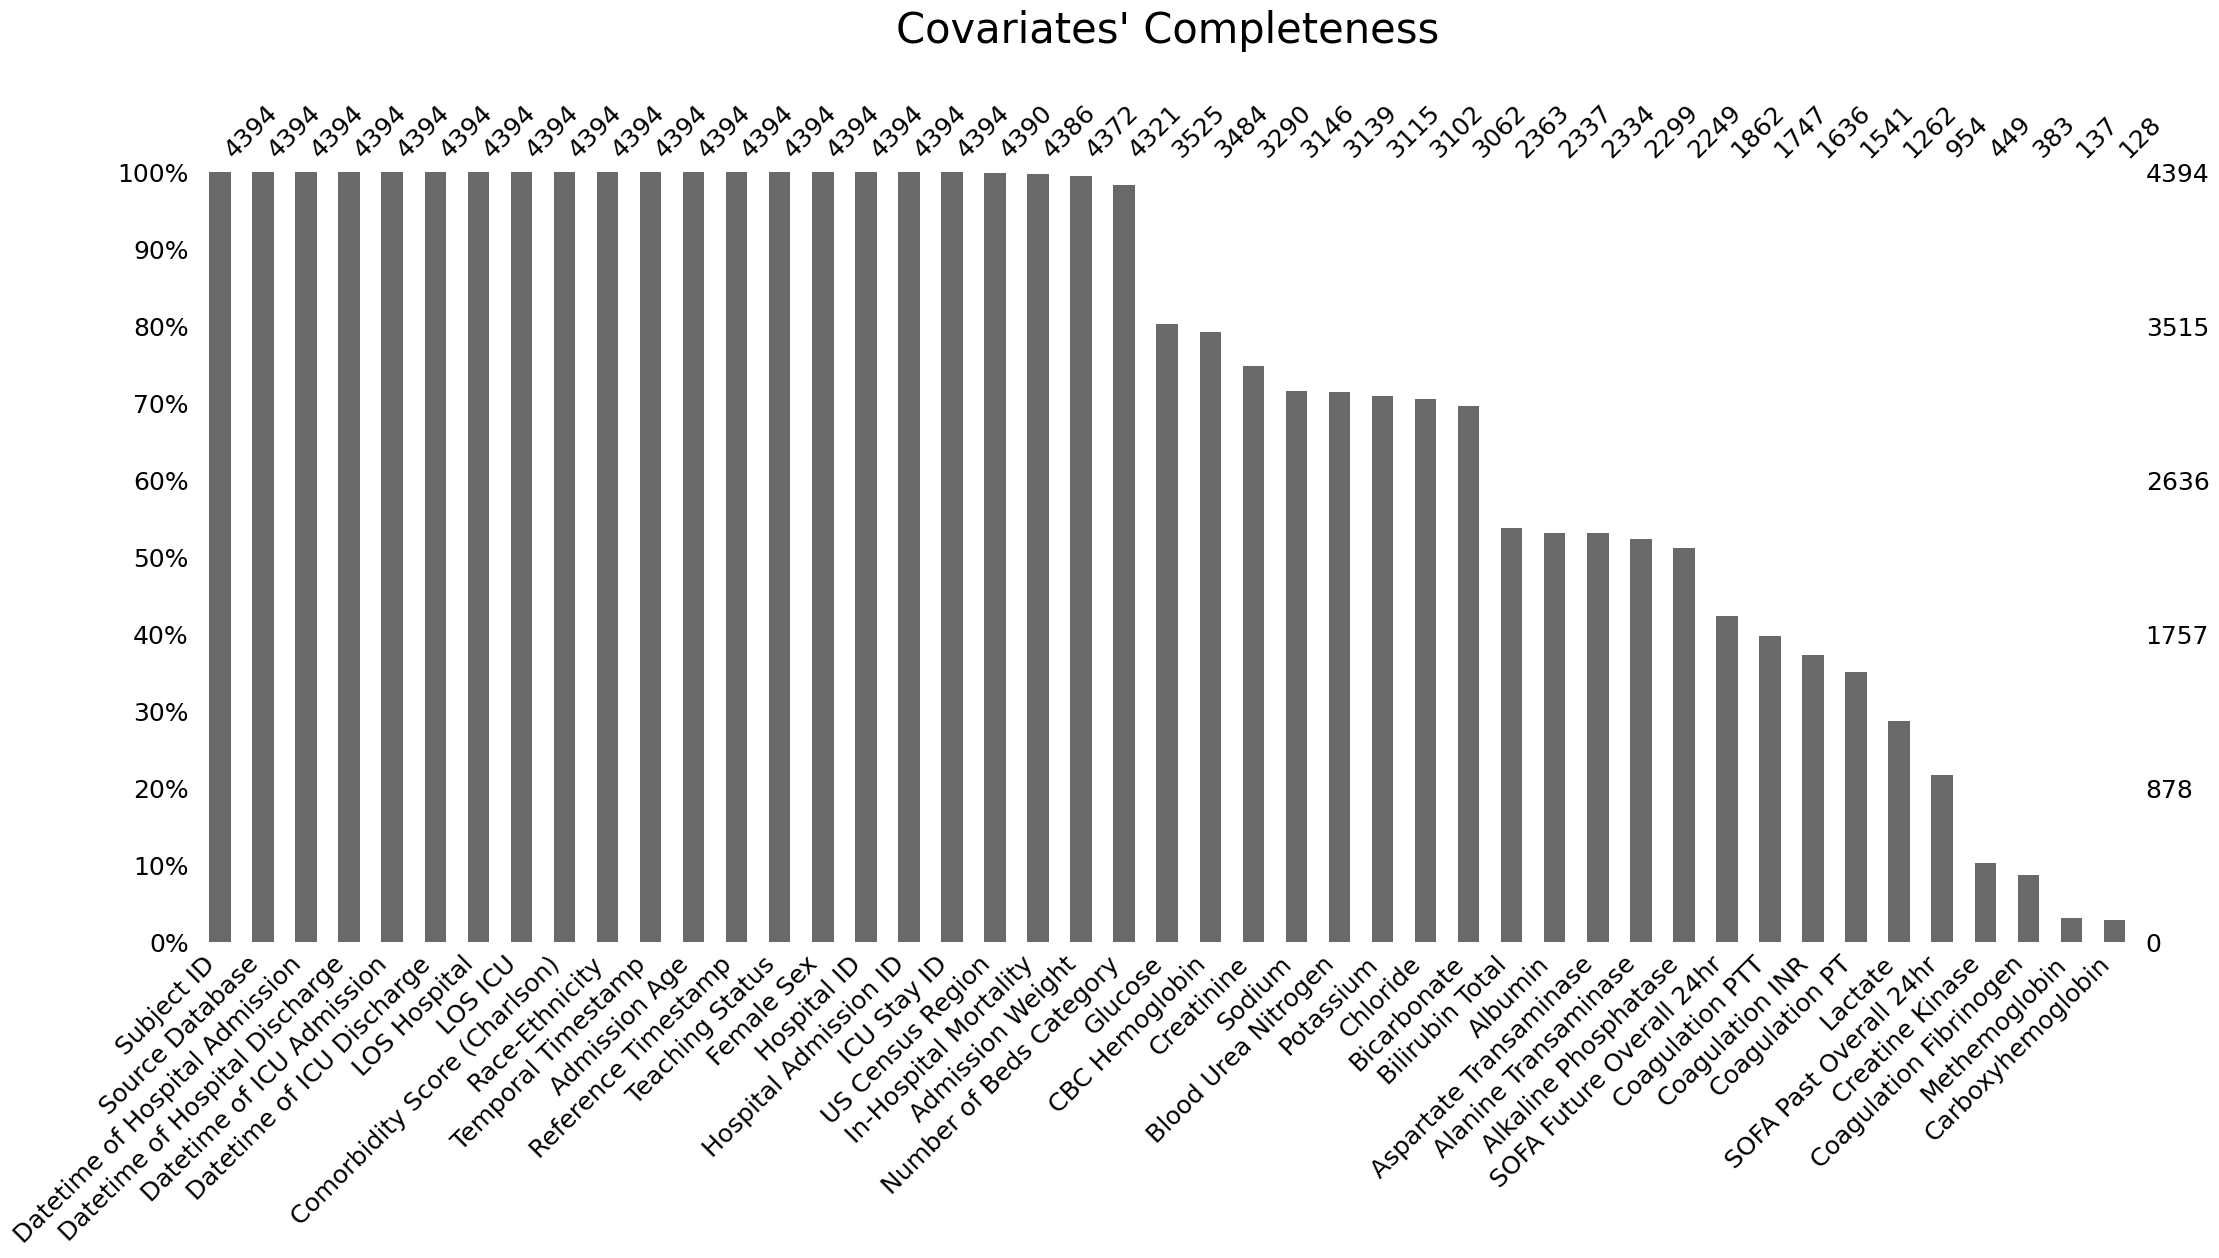

In [39]:
mdf = eicu2_final[[column for column in eicu2_final.columns if not column.startswith('delta_')]]

# Retain only columns of interest
mdf = mdf[columns_retained]

# Call the function to rename the columns
rename_columns(mdf, column_names_old, column_names_new)

# Plot Missingness Bar Chart

mdf_sorted = msno.nullity_sort(mdf, sort='descending') # or sort='ascending'
bar = msno.bar(mdf_sorted, filter='top', sort='descending', fontsize = 18,  label_rotation=45)

#bar.axes[0].tick_params(axis='y', labelsize=30)

# Modify y-axis labels to percentages
plt.yticks(np.arange(0, 1.1, 0.1), [str(int(x * 100)) + '%' for x in np.arange(0, 1.1, 0.1)])
plt.title("Covariates' Completeness\n", fontsize=30)
plt.show()